## Entrenamiento de BERT/BETO para la variable 'Town'

### Lectura y limpieza de datos

In [2]:
import pandas as pd 
import os
import numpy as np
from nltk.corpus import stopwords

ruta = "../data"
archivo = os.path.join(ruta, "Rest-Mex_2025_train.csv")

with open(archivo, "r", encoding="utf-8", errors = 'replace') as f:
    Data = pd.read_csv(f)

def arregla_mojibake(texto):
    try:
        return texto.encode('latin-1').decode('utf-8')
    except:
        return texto

Data['Title'] = Data['Title'].fillna('').apply(arregla_mojibake)
Data['Review'] = Data['Review'].fillna('').apply(arregla_mojibake)

# Creamos columna base con texto leído y concatenado
Data['Texto_Leido'] = (Data['Title'] + ' ' + Data['Review']).str.strip()

# Eliminamos columnas innecesarias
Data = Data.drop(columns=['Title', 'Review'])

### Veamos si hay desbalance en Town

C:\Users\uzgre\AppData\Local\Temp\ipykernel_14472\1298571392.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=town_counts.index, x=town_counts.values, palette="coolwarm")


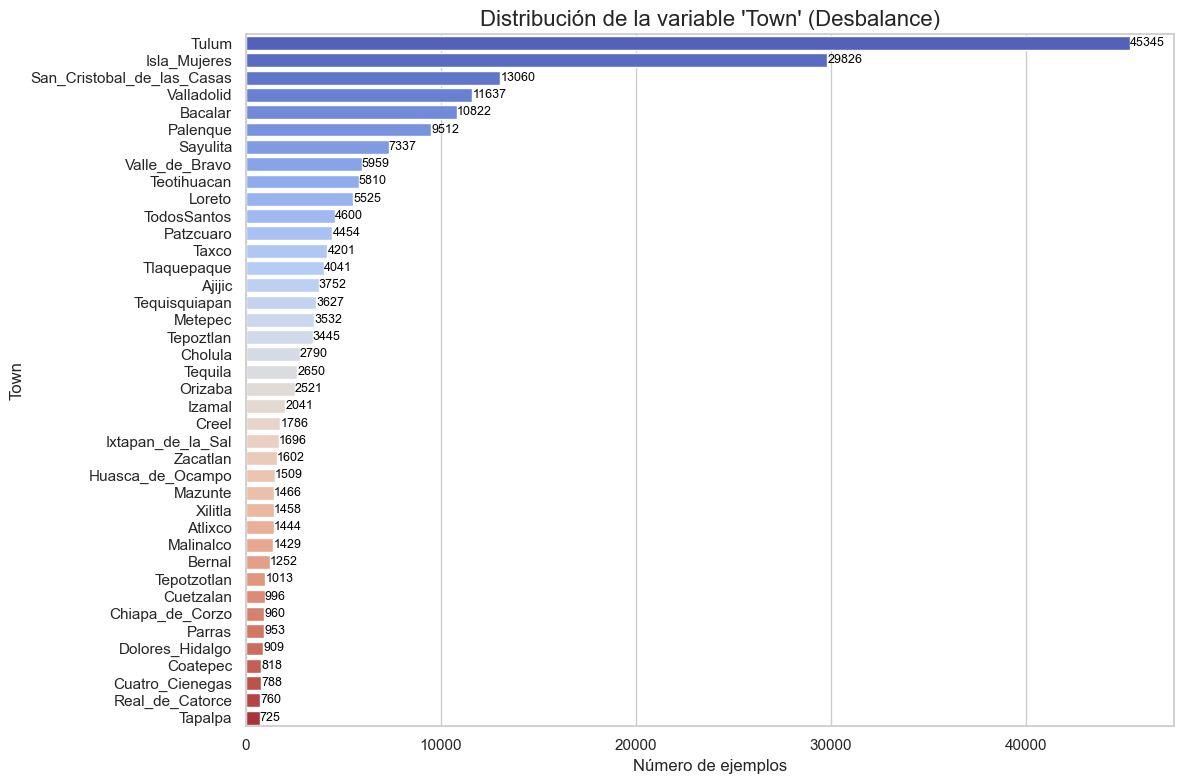

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo bonito
sns.set(style="whitegrid", palette="pastel")

# Conteo de Towns ordenado
town_counts = Data['Town'].value_counts()

# Tamaño de figura ajustado para que no se amontonen los nombres
plt.figure(figsize=(12, 8))

# Barplot horizontal para más elegancia
sns.barplot(y=town_counts.index, x=town_counts.values, palette="coolwarm")

# Títulos y etiquetas
plt.title("Distribución de la variable 'Town' (Desbalance)", fontsize=16)
plt.xlabel("Número de ejemplos", fontsize=12)
plt.ylabel("Town", fontsize=12)

# Mostrar valores en cada barra (opcional pero sexy)
for i, v in enumerate(town_counts.values):
    plt.text(v + 1, i, str(v), color='black', va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Verificamos CUDA

In [4]:
import torch 
print(torch.cuda.is_available()) # True si está disponible la GPU
print(torch.cuda.get_device_name(0)) # Nombre de la GPU

True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


### Clasificacion de Town con BETO

In [5]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from torch.nn import CrossEntropyLoss


# =========================
# BLOQUE 1: Preparar etiquetas para Town
# =========================
# Codificar Town como valores numéricos
town2id = {town: idx for idx, town in enumerate(Data['Town'].unique())}
id2town = {idx: town for town, idx in town2id.items()}

Data['label'] = Data['Town'].map(town2id)

# =========================
# BLOQUE 2: Tokenización y Datasets
# =========================
# Tokenizer BETO
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# Split train/validation
train_texts, val_texts, train_labels, val_labels = train_test_split(
    Data['Texto_Leido'].tolist(),
    Data['label'].tolist(),
    test_size=0.2,
    stratify=Data['label']
)

# Tokenización
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Dataset personalizado
class RMDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = RMDataset(train_encodings, train_labels)
val_dataset = RMDataset(val_encodings, val_labels)


In [7]:
# =========================
# BLOQUE 3: Modelo BETO para Town
# =========================
# Cálculo de pesos de clase (desbalanceo)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Modelo BETO para clasificación multiclase (Town)
num_towns = len(town2id)
model = AutoModelForSequenceClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=num_towns
)

# =========================
# BLOQUE 4: Trainer con pesos
# =========================
# Métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    f1_micro = f1_score(labels, preds, average='micro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    return {
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_micro": f1_micro,
        "f1_weighted": f1_weighted,
    }

# Trainer con pérdida ponderada
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=weights_tensor.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./resultados_beto_town",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs_town",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True
)

# =========================
# BLOQUE 5: Entrenamiento
# =========================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Entrenar (GPU si disponible)
trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\uzgre\anaconda3\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

### Guardamos eficientemente el modelo 

In [ ]:
output_dir = "./modelo_town"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Modelo y tokenizer guardados en {output_dir}")


### Borrar todo lo que no sea necesario (el checkpoint completo)

In [ ]:
import shutil

# Borra la carpeta donde se guardaron los checkpoints temporales
checkpoint_dir = "./resultados_beto_town"  # o como hayas nombrado esa carpeta
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
    print(f"Se ha eliminado la carpeta de checkpoints: {checkpoint_dir}")
else:
    print("No se encontraron checkpoints que borrar.")
